## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=9463428c-a1da-4ac3-8959-4f5537d909da
To: /Users/arthurchansel/Documents/School/EPFL/MASTER/2 NX-414 Brain-like computation and intelligence/brainlike/week6/IT_data.h5
100%|██████████| 384M/384M [00:17<00:00, 21.7MB/s] 


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


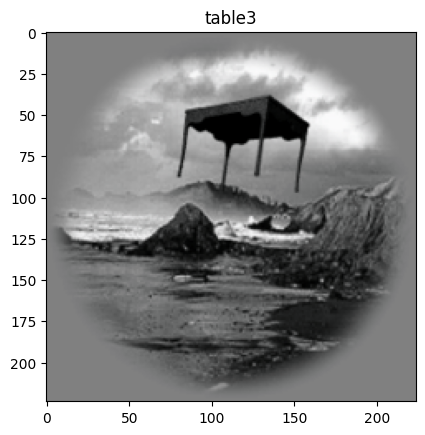

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

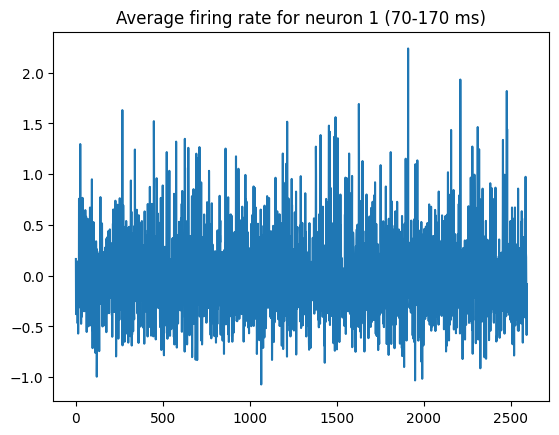

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [118]:
print(f"Input: images of shape {stimulus_train.shape}")
print(f"Output: neurons spikes of shape {spikes_train.shape}")

print(f'Train: {stimulus_train.shape[0]}')
print(f'Validation: {stimulus_val.shape[0]}')

Input: images of shape (2592, 3, 224, 224)
Output: neurons spikes of shape (2592, 168)
Train: 2592
Validation: 288


In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

X_train = stimulus_train.reshape(stimulus_train.shape[0], -1)
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
predictions = {}
print(f"X shape: train {X_train.shape} - val {X_val.shape}")

X shape: train (2592, 150528) - val (288, 150528)


In [120]:
# 1. Ridge Regression Model
ridge = Ridge()
ridge.fit(X_train, spikes_train)

# Predictions
predictions['ridge'] = ridge.predict(X_val)

/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.12002e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


In [121]:
# 2. Least Squares Regression Model
ls_model = LinearRegression()
ls_model.fit(X_train, spikes_train)

# Predictions
predictions['ls'] = ls_model.predict(X_val)

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

-- ls --
Mean EV: -0.033401232
Mean Pearson correlation: 0.21750107


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

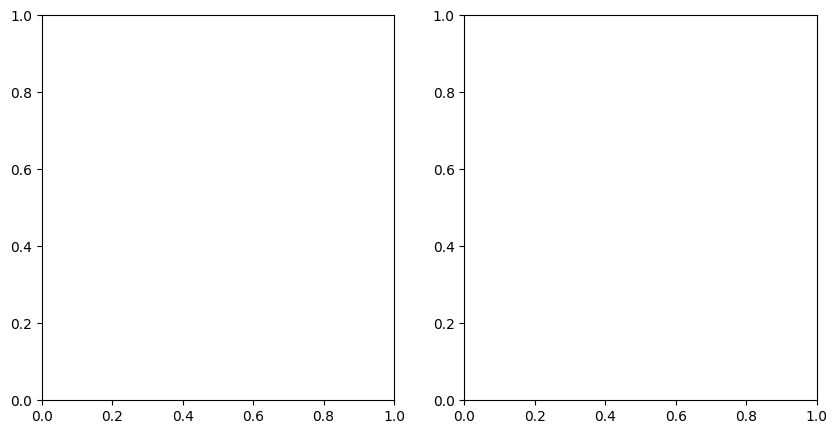

In [125]:
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
from typing import List

def evaluation_metrics(predictions, keys: List[str]=None):
    if keys!=None:
        nplots = len(keys)
    else:
        nplots = len(predictions)
    fig, axs = plt.subplots(len(predictions), 2, figsize=(10, 5))

    # For each prediction
    for idx, (key, pred) in enumerate(predictions.items()):
        if keys!=None and not key in keys:
            continue
        ev = explained_variance_score(spikes_val, pred, multioutput='raw_values')
        corr = np.array([pearsonr(x,y)[0] for (x,y) in zip(pred.T, spikes_val.T)])
        print(f"-- {key} --")
        print("Mean EV:", ev.mean())
        print("Mean Pearson correlation:", corr.mean())

        # Explained Variance
        axs[idx, 0].hist(ev, bins=30, edgecolor='black', alpha=0.7)
        axs[idx, 0].set_title(f'{key} - Explained Variance Score')
        axs[idx, 0].set_xlabel('Explained Variance')
        axs[idx, 0].set_ylabel('Number of Neurons')

        # Correlation
        axs[idx, 1].hist(corr, bins=30, edgecolor='black', alpha=0.7)
        axs[idx, 1].set_title(f'{key} - Correlation')
        axs[idx, 1].set_xlabel('Correlation Coefficient')
        axs[idx, 1].set_ylabel('Number of Neurons')

    plt.tight_layout()
    plt.show()

evaluation_metrics(predictions, ['ls'])

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
predictions_pca = {}

In [13]:
# 1. Ridge Regression Model
ridge = Ridge()
ridge.fit(X_train_reduced, spikes_train)

# Predictions
predictions_pca['ridge'] = ridge.predict(X_val_reduced)

In [14]:
# 2. Least Squares Regression Model
ls_model = LinearRegression()
ls_model.fit(X_train_reduced, spikes_train)

# Predictions
predictions_pca['ls'] = ls_model.predict(X_val_reduced)

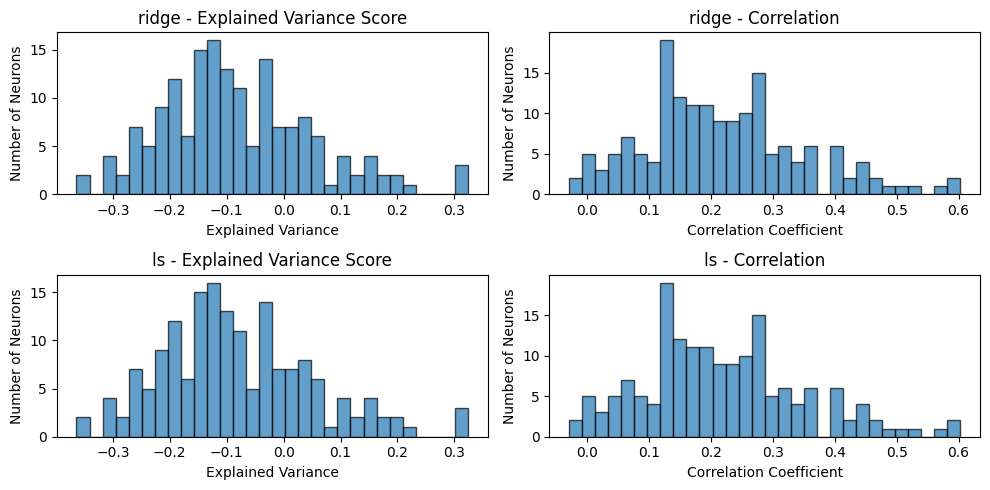

In [15]:
evaluation_metrics(predictions_pca)

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

Best alpha: 1000.0


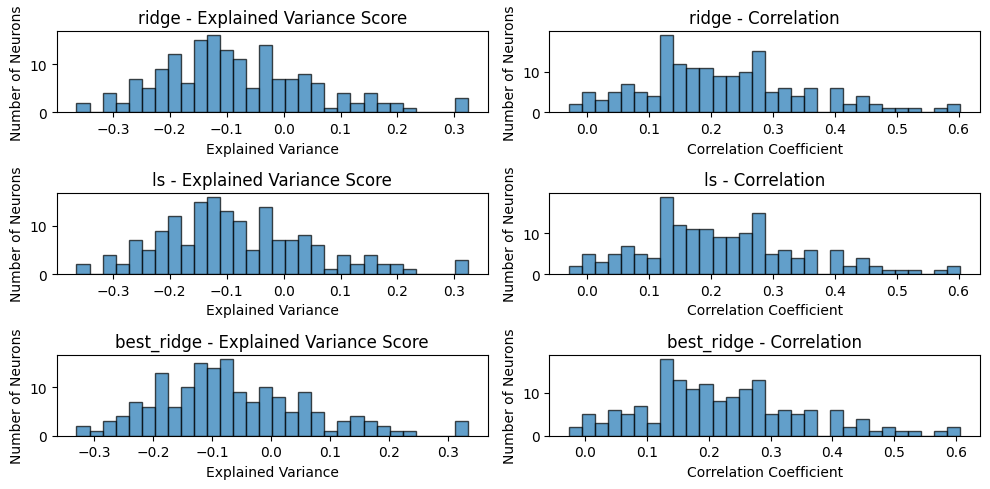

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Ridge Model
ridge = Ridge()

# Classes
label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(objects_train)

# Cross validation
param_grid = {'alpha': np.logspace(-3, 3, 10)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_ridge = GridSearchCV(ridge, param_grid, cv=cv.split(X_train_reduced, y_classes), scoring='r2', n_jobs=-1) # scoring: 'r2', 'explained_variance', 'neg_mean_squared_error'
cv_ridge.fit(X_train_reduced, spikes_train)

# Best model
best_ridge = cv_ridge.best_estimator_
print(f"Best alpha: {cv_ridge.best_params_['alpha']}")

predictions_pca['best_ridge'] = best_ridge.predict(X_val_reduced)
evaluation_metrics(predictions_pca)

In [17]:
from typing import Callable, Dict
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import numpy as np

def compare_metrics(metric_fn: Callable[[np.ndarray, np.ndarray], float],
                    y_true: np.ndarray,
                    predictions: Dict[str, np.ndarray],
                    metric_name: str) -> None:
    before = metric_fn(y_true, predictions['ridge'])
    after = metric_fn(y_true, predictions['best_ridge'])
    print(f"{metric_name}: after {after} - before {before}")
    print(f"{metric_name} residual {after - before}\n")

compare_metrics(mean_squared_error, spikes_val, predictions_pca, "MSE")
compare_metrics(r2_score, spikes_val, predictions_pca, "R2")
compare_metrics(explained_variance_score, spikes_val, predictions_pca, "EV")

MSE: after 0.14681699872016907 - before 0.14914973080158234
MSE residual -0.002332732081413269

R2: after -0.06974781304597855 - before -0.08721104264259338
R2 residual 0.017463229596614838

EV: after -0.06572329998016357 - before -0.08315054327249527
EV residual 0.017427243292331696



The different methods didn't significantly improved the predictions. We better try a new approach to get better results.

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [18]:
# Dataloader

import torch
from torch.utils.data import Dataset, DataLoader

class SpikesDataset(Dataset):
    def __init__(self, stimuli, spikes):
        self.stimuli = torch.tensor(stimuli, dtype=torch.float32)
        self.spikes = torch.tensor(spikes, dtype=torch.float32)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimulus = self.stimuli[idx]
        spike = self.spikes[idx]
        return stimulus, spike

train_dataset = SpikesDataset(stimulus_train, spikes_train)
val_dataset = SpikesDataset(stimulus_val, spikes_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Display 1st batch shape
for stimuli_batch, spikes_batch in train_loader:
    print(f"Stimuli batch shape: {stimuli_batch.shape}")
    print(f"Spikes batch shape: {spikes_batch.shape}")
    break

Stimuli batch shape: torch.Size([8, 3, 224, 224])
Spikes batch shape: torch.Size([8, 168])


In [20]:
# 1. Extract layers activations for the stimuli
import torchvision.models as models
import torch
import torch.nn as nn
device = "cpu"

layers = ['conv1','layer1','layer2','layer3','layer4','avgpool']
activations = {layer: [] for layer in layers}

# Setup forward hooks
def get_activation(name):
    def hook(model, input, output):
        activations[name].append(output.detach())
    return hook

# Setup model
model = models.resnet50(pretrained=True).to(device)
model.eval()
for name in layers:
    layer = dict([*model.named_modules()])[name]
    layer.register_forward_hook(get_activation(name))

# Forward pass
with torch.no_grad():
    for stimuli_batch, spikes_batch in train_loader:
        _ = model(stimuli_batch)

# Concat batch
for layer_name in activations:
    activations[layer_name] = torch.cat(activations[layer_name], dim=0)

# Activations for each layer
for layer_name, activation in activations.items():
    print(f"{layer_name}: {activations[layer_name].shape}")

/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/arthurchansel/anaconda3/envs/NX-414/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you c

conv1: torch.Size([2592, 64, 112, 112])
layer1: torch.Size([2592, 256, 56, 56])
layer2: torch.Size([2592, 512, 28, 28])
layer3: torch.Size([2592, 1024, 14, 14])
layer4: torch.Size([2592, 2048, 7, 7])
avgpool: torch.Size([2592, 2048, 1, 1])


In [22]:
# 2. Compute 1000 PCs, for each layer (one layer at a time, for memory)
from sklearn.decomposition import PCA

# PC per layer
def pc_layer(activations, n_components=1000):
    activation_flat = activations.view(activations.size(0), -1).cpu().numpy()
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(activation_flat)
    return pcs

layers_pcs = {}
for layer_name, activation in activations.items():
    pcs = pc_layer(activation)
    layers_pcs[layer_name] = pcs
    print(f"Layer {layer_name} - PCs Shape: {pcs.shape}")

Layer conv1 - PCs Shape: (2592, 1000)
Layer layer1 - PCs Shape: (2592, 1000)
Layer layer2 - PCs Shape: (2592, 1000)
Layer layer3 - PCs Shape: (2592, 1000)
Layer layer4 - PCs Shape: (2592, 1000)
Layer avgpool - PCs Shape: (2592, 1000)


In [43]:
# 3. Linear models to predict activity from PCs

pcs_train = [X_train] + list(layers_pcs.values()) + [spikes_train]
pcs_models = []

# Train models
for i in range(len(pcs_train)-1):
    ridge = Ridge()
    ridge.fit(pcs_train[i], pcs_train[i+1])
    pcs_models.append(ridge)

# Forward
def forward(x, models):
    out = x
    for model in models:
        out = model.predict(out)
    return out
pred = forward(X_val, pcs_models)

/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.12002e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


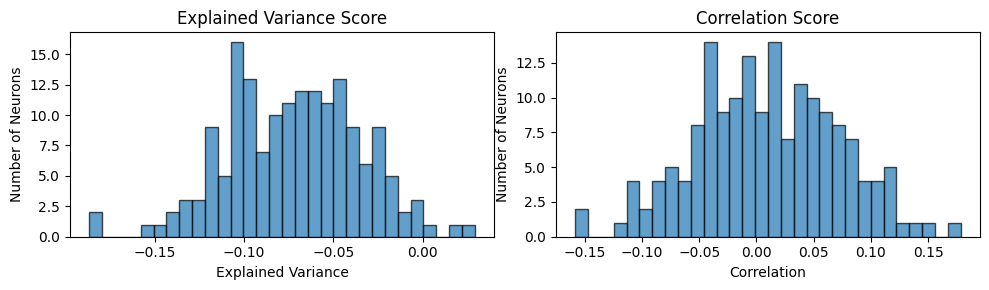

-- PCs --
Mean explained variance: -0.071830206
Mean Pearson correlation: 0.008694477
-- Baseline --
Mean explained variance: -0.0657233
Mean Pearson correlation: 0.22186734


In [103]:
# 4. Metrics: correlation, EV
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr

fig, axs = plt.subplots(1,2, figsize=(10,3))
axs = axs.ravel()

ev = explained_variance_score(spikes_val, pred, multioutput='raw_values')
axs[0].hist(ev, bins=30, edgecolor='black', alpha=0.7)
axs[0].set_title(f'Explained Variance Score')
axs[0].set_xlabel('Explained Variance')
axs[0].set_ylabel('Number of Neurons')

corr = np.array([pearsonr(x,y)[0] for (x,y) in zip(pred.T, spikes_val.T)])
axs[1].hist(corr, bins=30, edgecolor='black', alpha=0.7)
axs[1].set_title(f'Correlation Score')
axs[1].set_xlabel('Correlation')
axs[1].set_ylabel('Number of Neurons')

plt.tight_layout()
plt.show()

print("-- PCs --")
print("Mean explained variance:", ev.mean())
print("Mean Pearson correlation:", corr.mean())
print("-- Baseline --")
ev_baseline = explained_variance_score(spikes_val, predictions_pca['best_ridge'], multioutput='raw_values')
corr_baseline = np.array([pearsonr(x,y)[0] for (x,y) in zip(predictions_pca['best_ridge'].T, spikes_val.T)])
print("Mean explained variance:", ev_baseline.mean())
print("Mean Pearson correlation:", corr_baseline.mean())

In [ ]:
# 5. EV distribution per layer
ev_layer = {}

for layer in layers_pcs.keys():
    pass

conv1
layer1
layer2
layer3
layer4
avgpool


In [ ]:
# 6. Compare random and resnet50 on 1st layer

In [ ]:
def filter_dict_by_keys(dictionary: dict, keys: list) -> dict:
    """
    Filters a dictionary, keeping only the specified keys.

    Args:
        dictionary (dict): The dictionary to filter.
        keys (list): The list of keys to retain.

    Returns:
        dict: A filtered dictionary containing only the specified keys.
    """
    return {key: dictionary[key] for key in keys if key in dictionary}

# Example usage
example_dict = {"a": 1, "b": 2, "c": 3}
keys_to_keep = ["a", "c"]
filtered_dict = filter_dict_by_keys(example_dict, keys_to_keep)
print(filtered_dict)  # Output: {'a': 1, 'c': 3}